In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


# ============================================================================
# DATA COLLECTION
# ============================================================================

def get_klines(symbol="BTCUSDT", interval="5m", limit=1000):
    """Fetch OHLCV data from Binance."""
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol, "interval": interval, "limit": limit}
    
    raw = requests.get(url, params=params).json()
    
    cols = [
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_volume", "trades", 
        "taker_buy_base", "taker_buy_quote", "ignore"
    ]
    
    df = pd.DataFrame(raw, columns=cols)
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    
    numeric_cols = ["open", "high", "low", "close", "volume", 
                    "quote_volume", "taker_buy_base", "taker_buy_quote"]
    df[numeric_cols] = df[numeric_cols].astype(float)
    
    return df.drop('ignore', axis=1)


def get_funding_rates(symbol="BTCUSDT", limit=1000):
    """Fetch historical funding rates from Binance Futures."""
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    params = {"symbol": symbol, "limit": limit}
    
    raw = requests.get(url, params=params).json()
    df = pd.DataFrame(raw)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms")
    df["fundingRate"] = df["fundingRate"].astype(float)
    
    return df[["fundingTime", "fundingRate"]]


# ============================================================================
# CVD FEATURES
# ============================================================================

def calculate_cvd_features(df):
    """Calculate CVD approximation and related features."""
    df = df.copy()
    
    # CVD approximation
    df['buy_volume'] = df['taker_buy_base']
    df['sell_volume'] = df['volume'] - df['taker_buy_base']
    df['volume_delta'] = df['buy_volume'] - df['sell_volume']
    df['cvd'] = df['volume_delta'].cumsum()
    df['buy_sell_ratio'] = df['buy_volume'] / df['sell_volume'].replace(0, 1)
    
    # Rolling CVD features
    for window in [5, 10, 20]:
        df[f'cvd_slope_{window}'] = df['cvd'].diff(window) / window
        df[f'avg_volume_delta_{window}'] = df['volume_delta'].rolling(window).mean()
        df[f'avg_buy_sell_ratio_{window}'] = df['buy_sell_ratio'].rolling(window).mean()
    
    return df


# ============================================================================
# TECHNICAL INDICATORS
# ============================================================================

def calculate_technical_features(df):
    """Calculate technical indicators: volatility, momentum, trend."""
    df = df.copy()
    
    # === Returns ===
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # === Volatility ===
    # ATR (Average True Range)
    df['high_low'] = df['high'] - df['low']
    df['high_close'] = np.abs(df['high'] - df['close'].shift(1))
    df['low_close'] = np.abs(df['low'] - df['close'].shift(1))
    df['true_range'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
    df['atr_14'] = df['true_range'].rolling(14).mean()
    df['atr_20'] = df['true_range'].rolling(20).mean()
    
    # Realized volatility
    df['realized_vol_20'] = df['returns'].rolling(20).std()
    
    # Volatility regime (percentile-based)
    df['vol_percentile'] = df['atr_20'].rolling(100).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1] if len(x) > 0 else np.nan
    )
    
    # === Moving Averages ===
    for period in [10, 20, 50, 100]:
        df[f'sma_{period}'] = df['close'].rolling(period).mean()
        df[f'ema_{period}'] = df['close'].ewm(span=period, adjust=False).mean()
    
    # Distance from MAs
    df['price_to_sma_20'] = df['close'] / df['sma_20']
    df['price_to_sma_50'] = df['close'] / df['sma_50']
    
    # === RSI ===
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / loss
    df['rsi_14'] = 100 - (100 / (1 + rs))
    
    # === MACD ===
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_diff'] = df['macd'] - df['macd_signal']
    
    # === ADX (Average Directional Index) for trend strength ===
    # Calculate +DM and -DM
    high_diff = df['high'].diff()
    low_diff = -df['low'].diff()
    
    plus_dm = high_diff.where((high_diff > low_diff) & (high_diff > 0), 0)
    minus_dm = low_diff.where((low_diff > high_diff) & (low_diff > 0), 0)
    
    # Smooth with EMA
    atr_14 = df['atr_14']
    plus_di = 100 * (plus_dm.ewm(span=14, adjust=False).mean() / atr_14)
    minus_di = 100 * (minus_dm.ewm(span=14, adjust=False).mean() / atr_14)
    
    # Calculate DX and ADX
    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
    df['adx_14'] = dx.ewm(span=14, adjust=False).mean()
    df['plus_di'] = plus_di
    df['minus_di'] = minus_di
    
    # === Momentum ===
    for period in [5, 10, 20]:
        df[f'momentum_{period}'] = df['close'] - df['close'].shift(period)
        df[f'roc_{period}'] = df['close'].pct_change(period) * 100
    
    # === Volume ===
    df['volume_ma_20'] = df['volume'].rolling(20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma_20']
    df['volume_std_20'] = df['volume'].rolling(20).std()
    
    # Clean up intermediate columns
    df = df.drop(['high_low', 'high_close', 'low_close', 'true_range'], axis=1)
    
    return df


# ============================================================================
# REGIME FEATURES
# ============================================================================

def calculate_regime_features(df):
    """Calculate regime-based features: trend, volatility regime."""
    df = df.copy()
    
    # === Trend Regime (based on SMA relationship) ===
    # 1 = bullish, 0 = neutral, -1 = bearish
    df['trend_regime'] = 0
    df.loc[df['sma_20'] > df['sma_50'], 'trend_regime'] = 1
    df.loc[df['sma_20'] < df['sma_50'], 'trend_regime'] = -1
    
    # === Trend Alignment (multiple timeframes agree) ===
    df['trend_alignment'] = (
        (df['sma_10'] > df['sma_20']) & 
        (df['sma_20'] > df['sma_50']) & 
        (df['close'] > df['sma_10'])
    ).astype(int)
    
    # === Volatility Regime ===
    # Low/Medium/High based on percentile
    df['volatility_regime'] = pd.cut(
        df['vol_percentile'], 
        bins=[0, 0.33, 0.67, 1.0], 
        labels=['low', 'medium', 'high']
    )
    
    # === Trend Strength Regime (ADX-based) ===
    # Strong trend > 25, weak trend < 20
    df['trend_strength_regime'] = 'ranging'
    df.loc[df['adx_14'] > 25, 'trend_strength_regime'] = 'trending'
    df.loc[df['adx_14'] < 20, 'trend_strength_regime'] = 'weak'
    
    # === Momentum Persistence ===
    # Count consecutive bars with positive returns
    df['positive_returns'] = (df['returns'] > 0).astype(int)
    df['consecutive_up'] = df['positive_returns'].groupby(
        (df['positive_returns'] != df['positive_returns'].shift()).cumsum()
    ).cumsum()
    
    # Same for negative
    df['negative_returns'] = (df['returns'] < 0).astype(int)
    df['consecutive_down'] = df['negative_returns'].groupby(
        (df['negative_returns'] != df['negative_returns'].shift()).cumsum()
    ).cumsum()
    
    # Clean up
    df = df.drop(['positive_returns', 'negative_returns'], axis=1)
    
    return df


# ============================================================================
# TRIPLE BARRIER LABELING
# ============================================================================

def add_triple_barrier_labels(df, profit_pct=0.015, stop_pct=0.01, time_bars=20):
    """Add triple barrier labels to DataFrame."""
    df = df.copy()
    
    # Initialize columns
    df['label'] = np.nan
    df['barrier_hit'] = None
    df['return'] = np.nan
    df['bars_held'] = np.nan
    
    max_idx = len(df) - time_bars - 1
    
    for i in range(max_idx):
        entry_price = df['close'].iloc[i]
        upper_barrier = entry_price * (1 + profit_pct)
        lower_barrier = entry_price * (1 - stop_pct)
        
        barrier_hit = None
        bars_held = 0
        exit_price = entry_price
        
        for j in range(i + 1, min(i + time_bars + 1, len(df))):
            bars_held = j - i
            
            if df['high'].iloc[j] >= upper_barrier:
                barrier_hit = 'upper'
                exit_price = upper_barrier
                break
            
            if df['low'].iloc[j] <= lower_barrier:
                barrier_hit = 'lower'
                exit_price = lower_barrier
                break
        
        if barrier_hit is None:
            barrier_hit = 'time'
            exit_idx = min(i + time_bars, len(df) - 1)
            exit_price = df['close'].iloc[exit_idx]
            bars_held = exit_idx - i
        
        label = 1 if barrier_hit == 'upper' else (-1 if barrier_hit == 'lower' else 0)
        ret = (exit_price - entry_price) / entry_price
        
        df.iloc[i, df.columns.get_loc('label')] = label
        df.iloc[i, df.columns.get_loc('barrier_hit')] = barrier_hit
        df.iloc[i, df.columns.get_loc('return')] = ret
        df.iloc[i, df.columns.get_loc('bars_held')] = bars_held
    
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)
    df['bars_held'] = df['bars_held'].astype(int)
    
    return df


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def create_full_features_dataset(symbol="BTCUSDT", interval="5m", limit=1000,
                                profit_pct=0.015, stop_pct=0.01, time_bars=20):
    """
    Complete pipeline: fetch data, calculate all features, add labels.
    
    Returns:
        DataFrame with OHLCV, CVD, technical indicators, regimes, and labels.
    """
    print(f"Fetching {symbol} {interval} data...")
    klines_df = get_klines(symbol, interval, limit)
    
    print("Fetching funding rates...")
    funding_df = get_funding_rates(symbol, limit)
    
    print("Calculating CVD features...")
    df = calculate_cvd_features(klines_df)
    
    print("Calculating technical indicators...")
    df = calculate_technical_features(df)
    
    print("Calculating regime features...")
    df = calculate_regime_features(df)
    
    print("Merging funding rates...")
    df = pd.merge_asof(
        df.sort_values("close_time"),
        funding_df.sort_values("fundingTime"),
        left_on="close_time",
        right_on="fundingTime",
        direction="backward"
    )
    
    print("Generating triple barrier labels...")
    df = add_triple_barrier_labels(df, profit_pct, stop_pct, time_bars)
    
    print(f"\nDataset created: {len(df)} rows, {len(df.columns)} columns")
    print(f"\nLabel distribution:")
    print(df['label'].value_counts().sort_index())
    
    return df


# ============================================================================
# EXECUTE
# ============================================================================

# Create full dataset
df = create_full_features_dataset(
    symbol="BTCUSDT",
    interval="5m",
    limit=1000,
    profit_pct=0.005,  # 1.5% profit target
    stop_pct=0.01,     # 1% stop loss
    time_bars=20       # 100 minutes max hold
)

# Display info
print("\nDataset columns:")
print(df.columns.tolist())

print("\nSample rows:")
print(df[['close_time', 'close', 'rsi_14', 'adx_14', 'trend_regime', 
          'label', 'barrier_hit', 'return']].tail(10))

# Save
df.to_csv('full_features_with_labels.csv', index=False)
print("\nSaved to 'full_features_with_labels.csv'")

Fetching BTCUSDT 5m data...
Fetching funding rates...
Calculating CVD features...
Calculating technical indicators...
Calculating regime features...
Merging funding rates...
Generating triple barrier labels...

Dataset created: 979 rows, 69 columns

Label distribution:
label
-1    191
 0    320
 1    468
Name: count, dtype: int64

Dataset columns:
['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'trades', 'taker_buy_base', 'taker_buy_quote', 'buy_volume', 'sell_volume', 'volume_delta', 'cvd', 'buy_sell_ratio', 'cvd_slope_5', 'avg_volume_delta_5', 'avg_buy_sell_ratio_5', 'cvd_slope_10', 'avg_volume_delta_10', 'avg_buy_sell_ratio_10', 'cvd_slope_20', 'avg_volume_delta_20', 'avg_buy_sell_ratio_20', 'returns', 'log_returns', 'atr_14', 'atr_20', 'realized_vol_20', 'vol_percentile', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'price_to_sma_20', 'price_to_sma_50', 'rsi_14', 'macd', 'macd_signal', 'macd_diff', 'adx_14',

In [2]:
df.describe().to_csv('dataset_description.csv')

In [3]:
print(df.isna().sum().to_string())

open_time                  0
open                       0
high                       0
low                        0
close                      0
volume                     0
close_time                 0
quote_volume               0
trades                     0
taker_buy_base             0
taker_buy_quote            0
buy_volume                 0
sell_volume                0
volume_delta               0
cvd                        0
buy_sell_ratio             0
cvd_slope_5                5
avg_volume_delta_5         4
avg_buy_sell_ratio_5       4
cvd_slope_10              10
avg_volume_delta_10        9
avg_buy_sell_ratio_10      9
cvd_slope_20              20
avg_volume_delta_20       19
avg_buy_sell_ratio_20     19
returns                    1
log_returns                1
atr_14                    13
atr_20                    19
realized_vol_20           20
vol_percentile           118
sma_10                     9
ema_10                     0
sma_20                    19
ema_20        

In [4]:
data = df.dropna()

In [5]:
# drop open_time col 
data = data.drop('open_time', axis=1)

<Axes: >

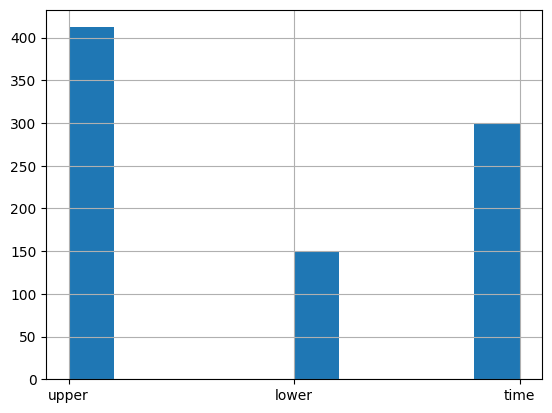

In [6]:
data.barrier_hit.hist()

In [7]:
data.head(2)

,open,high,low,close,volume,close_time,quote_volume,trades,taker_buy_base,taker_buy_quote,...,volatility_regime,trend_strength_regime,consecutive_up,consecutive_down,fundingTime,fundingRate,label,barrier_hit,return,bars_held
118,86651.99,87015.00,86629.43,86698.00,131.37085,2025-11-20 20:24:59.999,1.141450e+07,42328,72.51759,6.300905e+06,...,low,ranging,2,0,2025-11-20 16:00:00,0.00009,1,upper,0.005,11
119,86698.01,87067.93,86681.00,87056.71,90.93937,2025-11-20 20:29:59.999,7.899588e+06,34762,55.18303,4.793987e+06,...,medium,ranging,3,0,2025-11-20 16:00:00,0.00009,1,upper,0.005,15


In [8]:
# set time index to close_time
data = data.set_index('close_time')

# drop any time related columns now
data = data.drop(['fundingTime'], axis=1)

In [9]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'quote_volume', 'trades',
       'taker_buy_base', 'taker_buy_quote', 'buy_volume', 'sell_volume',
       'volume_delta', 'cvd', 'buy_sell_ratio', 'cvd_slope_5',
       'avg_volume_delta_5', 'avg_buy_sell_ratio_5', 'cvd_slope_10',
       'avg_volume_delta_10', 'avg_buy_sell_ratio_10', 'cvd_slope_20',
       'avg_volume_delta_20', 'avg_buy_sell_ratio_20', 'returns',
       'log_returns', 'atr_14', 'atr_20', 'realized_vol_20', 'vol_percentile',
       'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'sma_100',
       'ema_100', 'price_to_sma_20', 'price_to_sma_50', 'rsi_14', 'macd',
       'macd_signal', 'macd_diff', 'adx_14', 'plus_di', 'minus_di',
       'momentum_5', 'roc_5', 'momentum_10', 'roc_10', 'momentum_20', 'roc_20',
       'volume_ma_20', 'volume_ratio', 'volume_std_20', 'trend_regime',
       'trend_alignment', 'volatility_regime', 'trend_strength_regime',
       'consecutive_up', 'consecutive_down', 'fundingRate', 

In [10]:
# sample df 

sample_df = data[['cvd', 'cvd_slope_5', 'cvd_slope_10',
                  'avg_buy_sell_ratio_5', 'avg_buy_sell_ratio_10',
                  'atr_14', 'adx_14', 'momentum_10', 'roc_10',
                    'trend_regime',
                    'volume_ma_20',
                    'trend_alignment', 'fundingRate','consecutive_up',
                    'consecutive_down', 'label']]

In [11]:
sample_df.head(2)

,cvd,cvd_slope_5,cvd_slope_10,avg_buy_sell_ratio_5,avg_buy_sell_ratio_10,atr_14,adx_14,momentum_10,roc_10,trend_regime,volume_ma_20,trend_alignment,fundingRate,consecutive_up,consecutive_down,label
close_time,,,,,,,,,,,,,,,,
2025-11-20 20:24:59.999,-2564.19326,-3.864250,18.431201,1.263875,1.433914,335.771429,21.636999,43.74,0.050476,-1,208.355239,0,0.00009,2,0,1
2025-11-20 20:29:59.999,-2544.76657,-5.735214,12.400180,1.256988,1.435228,339.536429,23.619455,531.55,0.614330,-1,207.386141,0,0.00009,3,0,1


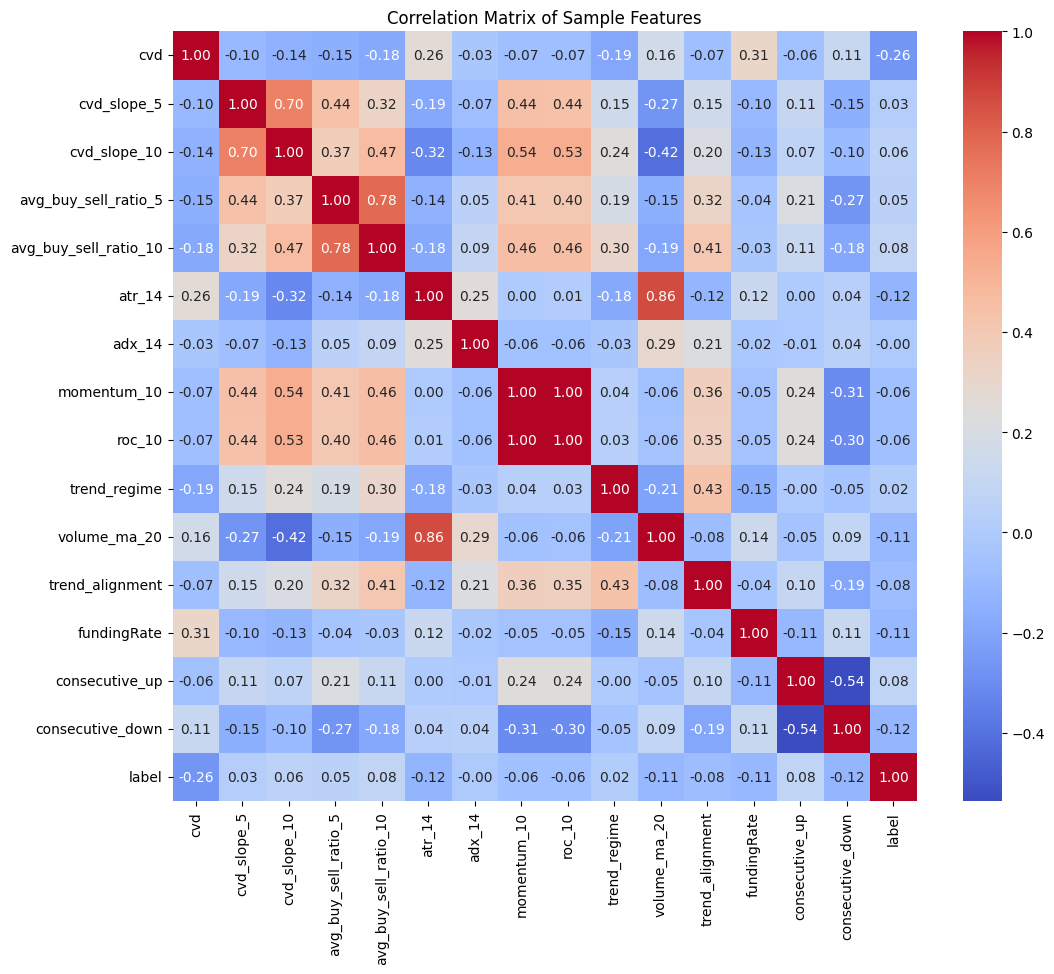

In [12]:
# plot correlation matrix of sample_df
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
corr = sample_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Sample Features")
plt.show()

In [13]:
sample_df.label.unique()

array([ 1, -1,  0])

In [14]:
# Separate features into X and y variables
X = sample_df.drop(['label'], axis=1)
y = sample_df['label']


In [15]:
# For time series: simple chronological split, NO shuffling
split_idx = int(len(sample_df) * 0.8)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

In [16]:
# check to confirm that X_train and y_train have same datetime index
print(X_train.index.equals(y_train.index))
print(X_test.index.equals(y_test.index))


True
True


In [17]:
X_train.describe()

,cvd,cvd_slope_5,cvd_slope_10,avg_buy_sell_ratio_5,avg_buy_sell_ratio_10,atr_14,adx_14,momentum_10,roc_10,trend_regime,volume_ma_20,trend_alignment,fundingRate,consecutive_up,consecutive_down
count,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000
mean,-6691.385894,-6.896464,-6.783641,1.123042,1.125824,262.559564,35.634592,-3.566453,-0.001119,0.052326,141.927274,0.183140,0.000044,0.802326,1.047965
std,1777.943984,43.790496,30.715739,0.366466,0.286028,129.362544,12.538589,653.631933,0.776193,0.999357,149.788358,0.387062,0.000020,1.101221,1.415971
min,-8381.656340,-429.471608,-230.462706,0.467761,0.553169,89.908571,13.217867,-2211.230000,-2.581325,-1.000000,18.688284,0.000000,0.000014,0.000000,0.000000
25%,-7888.585273,-10.770635,-9.412013,0.845141,0.921002,171.132500,27.257778,-338.352500,-0.393766,-1.000000,52.452177,0.000000,0.000026,0.000000,0.000000
50%,-7356.512840,-1.156123,-1.347575,1.060448,1.076188,227.197857,33.664922,18.925000,0.022149,1.000000,84.569598,0.000000,0.000043,0.000000,1.000000
75%,-6675.656640,6.139155,5.782920,1.334241,1.305505,319.542500,41.828725,348.990000,0.418210,1.000000,147.616199,0.000000,0.000051,1.000000,2.000000
max,-2478.010380,108.211390,51.329940,2.548037,2.213911,676.104286,84.460900,3209.690000,3.965240,1.000000,709.008113,1.000000,0.000090,6.000000,8.000000


In [18]:
features_to_scale = [
    'cvd',                    # Large negative values, wide range
    'cvd_slope_5',            # Can be large positive/negative
    'cvd_slope_10',           # Can be large positive/negative
    'atr_14',                 # Absolute price values, needs scaling
    'momentum_10',            # Large range (-2211 to 3209)
    'volume_ma_20',           # Large absolute values
    'consecutive_up',         # Counts can grow
    'consecutive_down'        # Counts can grow
]

# Features already bounded or meaningful without scaling
features_no_scale = [
    'avg_buy_sell_ratio_5',   # Ratios are already meaningful
    'avg_buy_sell_ratio_10',  # Ratios are already meaningful
    'adx_14',                 # Bounded 0-100
    'roc_10',                 # Rate of change, already % based, small range
    'trend_regime',           # Categorical (-1, 0, 1)
    'trend_alignment',        # Binary (0, 1)
    'fundingRate'             # Already small decimals (0.00001 range)
]

In [19]:
# Scaling 
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit ONLY on training data for columns that need scaling
scaler.fit(X_train[features_to_scale])

print(f"Scaler fitted on {len(X_train)} training samples")
print(f"\nScaler learned these means:")
print(pd.Series(scaler.mean_, index=features_to_scale))
print(f"\nScaler learned these stds:")
print(pd.Series(scaler.scale_, index=features_to_scale))

Scaler fitted on 688 training samples

Scaler learned these means:
cvd                -6691.385894
cvd_slope_5           -6.896464
cvd_slope_10          -6.783641
atr_14               262.559564
momentum_10           -3.566453
volume_ma_20         141.927274
consecutive_up         0.802326
consecutive_down       1.047965
dtype: float64

Scaler learned these stds:
cvd                 1776.651404
cvd_slope_5           43.758660
cvd_slope_10          30.693408
atr_14               129.268496
momentum_10          653.156737
volume_ma_20         149.679460
consecutive_up         1.100420
consecutive_down       1.414942
dtype: float64


In [20]:
# Transform training data
X_train_scaled = X_train.copy()
X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

# Transform test data with SAME scaler (no refitting!)
X_test_scaled = X_test.copy()
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

print("Scaling complete")
print(f"\nTraining data after scaling (first 5 rows):")
print(X_train_scaled[features_to_scale].head())

Scaling complete

Training data after scaling (first 5 rows):
                              cvd  cvd_slope_5  cvd_slope_10    atr_14  \
close_time                                                               
2025-11-20 20:24:59.999  2.323018     0.069294      0.821507  0.566355   
2025-11-20 20:29:59.999  2.333952     0.026538      0.625014  0.595480   
2025-11-20 20:34:59.999  2.322844    -0.099869      0.590790  0.597354   
2025-11-20 20:39:59.999  2.300180     0.187958      0.388026  0.464789   
2025-11-20 20:44:59.999  2.293536    -0.019344      0.249337  0.400532   

                         momentum_10  volume_ma_20  consecutive_up  \
close_time                                                           
2025-11-20 20:24:59.999     0.072427      0.443801        1.088379   
2025-11-20 20:29:59.999     0.819277      0.437327        1.997123   
2025-11-20 20:34:59.999     0.128448      0.366305       -0.729108   
2025-11-20 20:39:59.999     0.217523      0.315979       -0.729108   

In [24]:
X_train_scaled.head(2)

,cvd,cvd_slope_5,cvd_slope_10,avg_buy_sell_ratio_5,avg_buy_sell_ratio_10,atr_14,adx_14,momentum_10,roc_10,trend_regime,volume_ma_20,trend_alignment,fundingRate,consecutive_up,consecutive_down
close_time,,,,,,,,,,,,,,,
2025-11-20 20:24:59.999,2.323018,0.069294,0.821507,1.263875,1.433914,0.566355,21.636999,0.072427,0.050476,-1,0.443801,0,0.00009,1.088379,-0.740642
2025-11-20 20:29:59.999,2.333952,0.026538,0.625014,1.256988,1.435228,0.595480,23.619455,0.819277,0.614330,-1,0.437327,0,0.00009,1.997123,-0.740642


In [32]:
# Model training with cross validation- single model example
from sklearn.model_selection import TimeSeriesSplit
# from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Use TimeSeriesSplit for time series data (respects temporal order) - random seed on
tscv = TimeSeriesSplit(n_splits=5)

cv_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"\n{'='*60}")
    print(f"Fold {fold + 1}/5")
    print(f"{'='*60}")
    
    # Split fold data
    X_fold_train = X_train.iloc[train_idx].copy()
    X_fold_val = X_train.iloc[val_idx].copy()
    y_fold_train = y_train.iloc[train_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # CRITICAL: Fit new scaler on THIS fold's training data only
    fold_scaler = StandardScaler()
    fold_scaler.fit(X_fold_train[features_to_scale])
    
    # Transform both fold train and validation
    X_fold_train_scaled = X_fold_train.copy()
    X_fold_train_scaled[features_to_scale] = fold_scaler.transform(
        X_fold_train[features_to_scale]
    )
    
    X_fold_val_scaled = X_fold_val.copy()
    X_fold_val_scaled[features_to_scale] = fold_scaler.transform(
        X_fold_val[features_to_scale]
    )
    
    # Train model on this fold
    model = LogisticRegression(max_iter=1000)
    model.fit(X_fold_train_scaled, y_fold_train)
    
    # Predict on validation set
    y_pred = model.predict(X_fold_val_scaled)
    
    # Evaluate
    fold_accuracy = accuracy_score(y_fold_val, y_pred)
    cv_scores.append(fold_accuracy)
    
    print(f"Fold {fold + 1} Accuracy: {fold_accuracy:.4f}")
    print(f"Train size: {len(X_fold_train)}, Val size: {len(X_fold_val)}")

print(f"\n{'='*60}")
print("Cross-Validation Results")
print(f"{'='*60}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")
print(f"Std CV Accuracy: {np.std(cv_scores):.4f}")
print(f"CV Scores: {cv_scores}")


Fold 1/5
Fold 1 Accuracy: 0.1930
Train size: 118, Val size: 114

Fold 2/5
Fold 2 Accuracy: 0.3070
Train size: 232, Val size: 114

Fold 3/5
Fold 3 Accuracy: 0.2719
Train size: 346, Val size: 114

Fold 4/5
Fold 4 Accuracy: 0.6316
Train size: 460, Val size: 114

Fold 5/5
Fold 5 Accuracy: 0.3421
Train size: 574, Val size: 114

Cross-Validation Results
Mean CV Accuracy: 0.3491
Std CV Accuracy: 0.1496
CV Scores: [0.19298245614035087, 0.30701754385964913, 0.2719298245614035, 0.631578947368421, 0.34210526315789475]


In [ ]:
# No cross validation training 
# Split fold data
    X_fold_train = X_train.iloc[train_idx].copy()
    X_fold_val = X_train.iloc[val_idx].copy()
    y_fold_train = y_train.iloc[train_idx]
    y_fold_val = y_train.iloc[val_idx]